<a href="https://colab.research.google.com/github/neto-riga/Projects-DS/blob/main/Interrupted_Time_Series_INPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interrupted Time Series
### Ernesto Rivera Gálvez

Este notebook está básado en el [ejemplo de PyMC](https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html)

Las [series de tiempo interrumpidas](https://en.wikipedia.org/wiki/Interrupted_time_series) (también conocidas como quasi-experimental análisis de series de tiempo) son un método de análisis estadístico que trata de un seguimiento de un largo periodo anterior y posterior a un punto de intervención; lo que se busca es evaluar el efecto de la intervención.

Por ejemplo, si se realizó un cambio en un sitio web y quieres conocer el impacto causal de dicho cambio, entonces si este cambio se aplicó de manera selectiva y aleatoria a un grupo de prueba de usuarios del sitio web, entonces podrías hacer afirmaciones causales utilizando el enfoque de pruebas A/B.

Sin embargo, si el cambio en el sitio web se implementó para todos los usuarios del mismo, entonces no tienes un grupo de control. En este caso, no tienes una medición directa del contrafactual, lo que habría ocurrido si no se hubiera realizado el cambio en el sitio web. En este caso, si cuentas con datos de un 'buen' número de puntos temporales, entonces podrías utilizar el enfoque de series de tiempo interrumpidas.


## Causal DAG




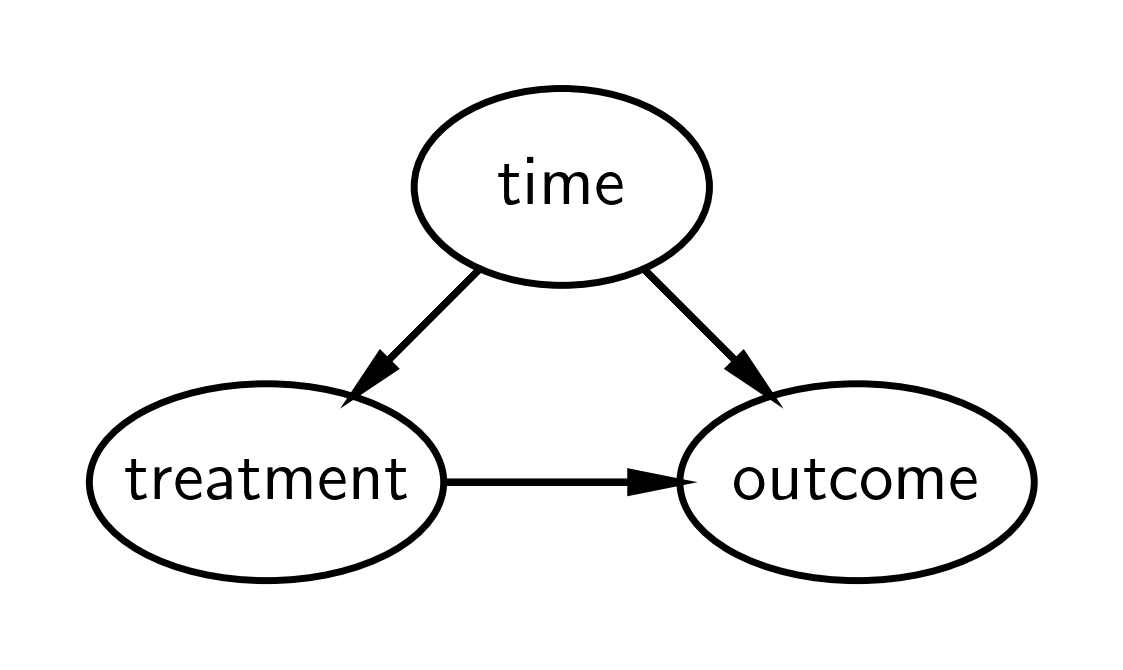

Como vimos en la plática, al tratar de efectos causales se suele utilizar un Gráfico, estos son conocidos como Gráfico Acíclico Dirigido Causal (DAG). Este es el DAG más básico para las series de tiempo interrumpidas, que indica básicamente:

**Interpretación Causal**
1. **Efecto del Tiempo:** El tiempo tiene un efecto directo sobre el resultado y un efecto indirecto a través del tratamiento.

2. **Efecto del Tratamiento:** El tratamiento afecta al resultado, pero este efecto también podría estar modulado por el tiempo, lo que indica que el impacto del tratamiento en el resultado puede cambiar dependiendo del periodo de tiempo en el que se administra o se evalúa el tratamiento.

Intuitivamente, podríamos describir la lógica del enfoque como:
* Sabemos que el resultado varía a lo largo del tiempo.
* Si construimos un modelo de cómo varía el resultado a lo largo del tiempo _antes_ del tratamiento, entonces podemos predecir el contrafactual de lo que esperaríamos que ocurriese _si_ el tratamiento no hubiera ocurrido.
* Podemos comparar este contrafactual con las observaciones desde el momento de la intervención en adelante. Si hay una discrepancia significativa, entonces podemos atribuir esto como un impacto causal de la intervención.

In [ ]:
# @title
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import seaborn as sns
import plotly.express as px

from scipy.stats import norm

colors = sns.color_palette('tab10')
sns.set_theme(palette='tab10')

In [ ]:
# @title
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Utilizaremos los [datos](https://www.datos.gob.mx/busca/dataset/indice-nacional-de-precios-al-consumidor-inpc1) del Índice nacional de precios al consumidor (INPC) mensuales y sus diferentes clasificaciones proporcionados por el INEGI en la página de Datos Abiertos México.

In [ ]:
df = pd.read_csv('./conjunto_de_datos_inpc_mensual.csv')
df['FECHA'] = pd.to_datetime(df.FECHA, format='%d/%m/%Y')
df.set_index('FECHA', inplace=True)
df['CONCEPTO_KEY'] = df.CONCEPTO.apply(lambda x: x[102:])
df_orig = df.copy()
df.sample(5)

,COBERTURA,PERIODICIDAD,CONCEPTO,VALOR,UNIDAD_MEDIDA,ESTATUS,CONCEPTO_KEY
FECHA,,,,,,,
2014-11-01,Nacional,Mensual,Índice nacional de precios al consumidor (mens...,83.218522,Índice,Cifras definitivas,No subyacente
2010-09-01,Nacional,Mensual,Índice nacional de precios al consumidor (mens...,77.482808,Índice,Cifras definitivas,Subyacente
2011-01-01,Nacional,Mensual,Índice nacional de precios al consumidor (mens...,81.680738,Índice,Cifras definitivas,"Subyacente, Servicios"
2017-06-01,Nacional,Mensual,Índice nacional de precios al consumidor (mens...,88.765149,Índice,Cifras definitivas,"No subyacente, Energéticos y tarifas autorizad..."
2017-11-01,Nacional,Mensual,Índice nacional de precios al consumidor (mens...,97.311981,Índice,Cifras definitivas,"No subyacente, Energéticos y tarifas autorizad..."


In [ ]:
fig = px.line(df, y='VALOR', x=df.index, color='CONCEPTO_KEY',
              title='Índice nacional de precios al consumidor',
              labels={'x': 'Fecha', 'VALOR': 'Índice', 'CONCEPTO_KEY': 'Concepto'})

fig.update_layout(width=1200, height=600)

fig.show()

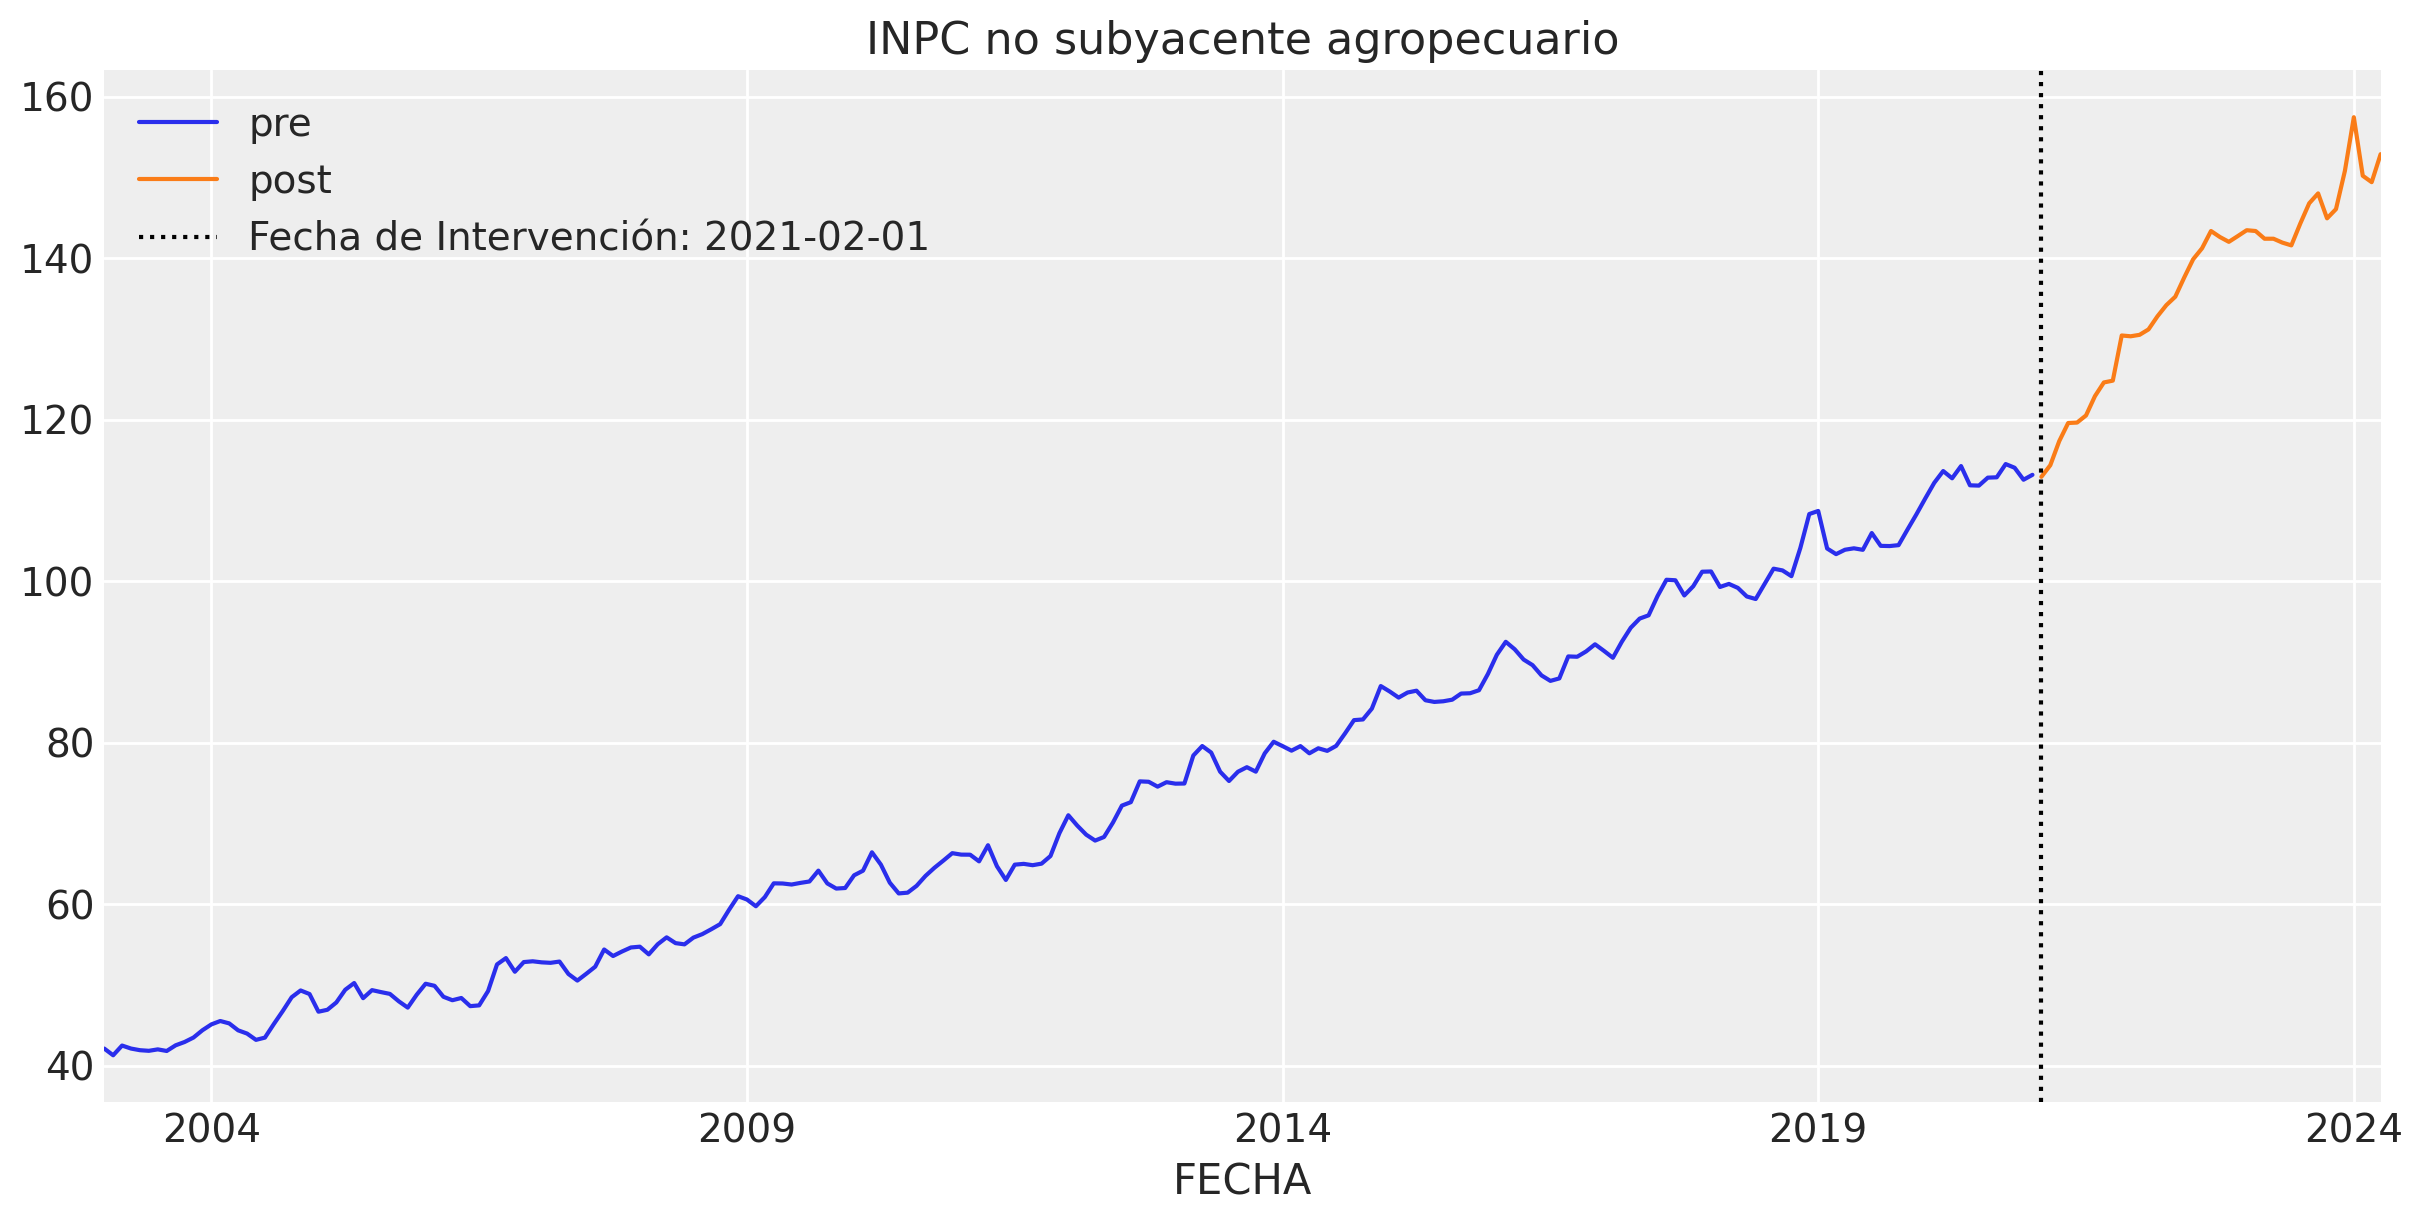

In [ ]:
treatment_time = '2021-02-01'
df = df[df.CONCEPTO_KEY == 'No subyacente, Agropecuarios']
df = df.sort_index()
df['time'] = range(len(df))
pre = df[(df.index < treatment_time)]
post = df[(df.index >= treatment_time)]

fig, ax = plt.subplots()
ax = pre["VALOR"].plot(label="pre", figsize=(12,6))
plt.title('INPC no subyacente agropecuario')
post["VALOR"].plot(ax=ax, label="post")
ax.axvline(treatment_time, c="k", ls=":", label=f'Fecha de Intervención: {treatment_time}')
plt.legend();

El Índice Nacional de Precios al Consumidor (INPC) es un indicador que mide la variación promedio de los precios de una canasta de bienes y servicios en México. Se divide en dos componentes: el subyacente (que excluye los bienes y servicios más volátiles) y el no subyacente (que incluye productos como alimentos, energéticos y tarifas gubernamentales)

De acuerdo al Banco Interamericano de Desarrollo (BID) describe en el libro [Políticas agrícolas en México: una visión agregada y un análisis de programas clave](https://publications.iadb.org/es/politicas-agricolas-en-mexico-una-vision-agregada-y-un-analisis-de-programas-clave) describe una posible explicación de este fenómeno.

Para entender esto entendamos dos **conceptos clave**:
1. **EAP (Estimado de Apoyo a los Productores):** Es una medida que estima el total de apoyos proporcionados a los productores, generalmente en términos monetarios o como un porcentaje de los ingresos totales de la agricultura.
2. **APM (Apoyos vía Precios de Mercado):** Es una parte del EAP que refleja los apoyos que afectan directamente los precios de mercado, como pueden ser las restricciones al comercio que alteran los precios internos en comparación con los precios internacionales.

El libro indica los siguientes **puntos clave**:
1. **Reducción del EAP (1990-2020):** El Estimado de Apoyo a los Productores ha disminuido significativamente desde el inicio de los noventa, cayendo del 25% al 10% en el período analizado hasta el trienio (2018-2020). Esto indica una tendencia hacia la reducción del apoyo estatal total a los productores.
2. **Cambios en la Composición del EAP (2004-2017)**: La proporción de los apoyos proporcionados a través de precios de mercado (APM), especialmente aquellos derivados de restricciones al comercio, ha disminuido de 50% en 2004 a 25% en 2017. Esto muestra un movimiento hacia menos manipulación de precios y más apoyos directos, que pueden incluir subvenciones, incentivos financieros, etc.
3. **Incremento del APM Post-2018**: Después de 2018, se observa un incremento en la proporción del APM, que llegó al 50% del EAP en el período 2018-20. Esto significa que la *mitad del apoyo total* a los productores en ese trienio fue *a través de mecanismos que influyen en los precios del mercado*, como las restricciones al comercio.

##### Implicaciones de un APM al 50% del EAP:
1. **Mayor Dependencia de Políticas de Precio**: Un aumento del APM al 50% del EAP sugiere que ha habido un retorno o un incremento en la dependencia de políticas que afectan directamente los precios de mercado para apoyar a los productores.

Algunas funciones para plotear el modelo

In [ ]:
# @title
def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

## Modelado

Aquí construimos un modelo lineal simple. Recuerda que estamos construyendo un modelo de los datos pre-intervención con el objetivo de que haga un trabajo razonable pronosticando lo que habría ocurrido si la intervención no se hubiera aplicado. Dicho de otra manera, no estamos modelando ningún aspecto de las observaciones post-intervención, como un cambio en la intercepción, la pendiente o si el efecto es transitorio o permanente.

In [ ]:
with pm.Model() as model:
    # observed predictors and outcome
    time = pm.MutableData("time", pre["time"].to_numpy(), dims="obs_id")
    # priors
    beta0 = pm.Normal("beta0", 41, 1)
    beta1 = pm.Normal("beta1", 0, 0.8)
    beta2 = pm.Normal("beta2", 0, 0.2)
    # the actual linear model
    mu = pm.Deterministic("mu", beta0 + (beta1 * time) + (beta2 * time ** 2), dims="obs_id")
    sigma = pm.HalfNormal("sigma", 2)
    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=pre["VALOR"].to_numpy(), dims="obs_id")

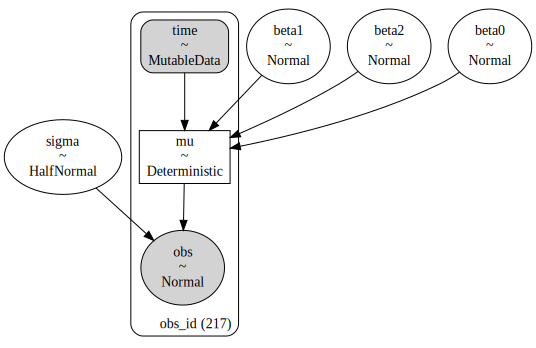

In [ ]:
pm.model_to_graphviz(model)

### Resumen del Modelo Bayesiano Lineal

#### Componentes del Modelo
- **Variables:**
  - `time`: Variable independiente, definida como `MutableData`, permitiendo actualizaciones sin reconstruir el modelo.
  - `beta0`, `beta1` y `beta2`: Coeficientes del modelo, todos modelados como distribuciones `Normal`. `beta0` es la intercepción y `beta1` la pendiente.
  - `mu`: Valor medio esperado del modelo, calculado de forma determinista como `beta0 + beta1 * time +  beta2 * time²`.
  - `sigma`: Desviación estándar de los errores del modelo, modelada como una distribución `HalfNormal`.

#### Estructura del Modelo
- **Relaciones:**
  - `time` influye directamente en `mu`, indicando cómo varía la respuesta a lo largo del tiempo.
  - `mu` es la base para la distribución de `obs`, la cual modela los datos observados.
  
#### Funcionalidad del Modelo
- **Predicción y Ajuste:**
  - `mu` y `sigma` definen una distribución `Normal` para `obs`, donde `obs` son los valores observados, permitiendo estimar el impacto de `time` sobre estos valores.

## Prior predictive check

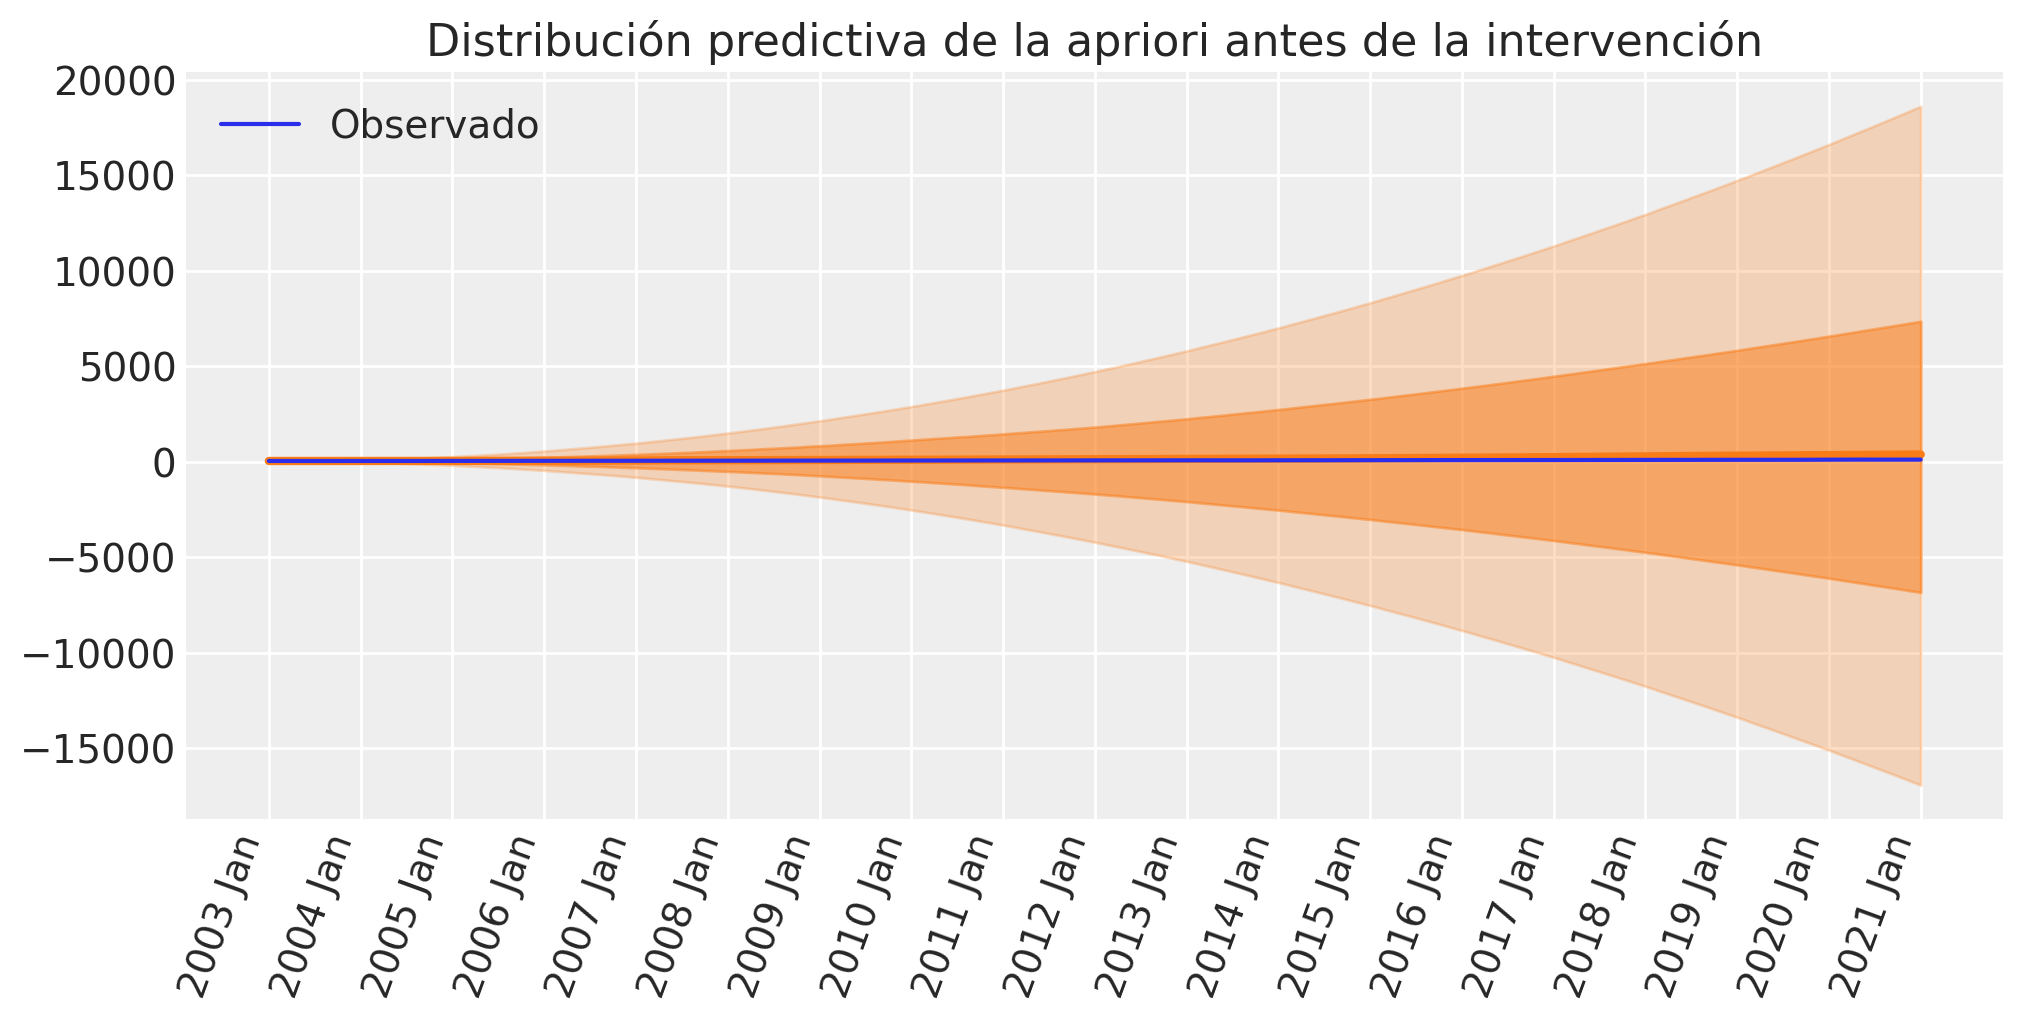

In [ ]:
with model:
    idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, idata.prior_predictive["obs"], ax)
format_x_axis(ax)
ax.plot(pre.index, pre["VALOR"], label="Observado")
ax.set(title="Distribución predictiva de la apriori antes de la intervención")
plt.legend();

Esto parece razonable en el sentido de que los priors sobre la intersección y la pendiente son lo suficientemente amplios como para llevar a observaciones predichas que contienen fácilmente los datos reales. Esto significa que los priors particulares elegidos no restringirán indebidamente las estimaciones de los parámetros posteriores.

## Inferencia
Extrae muestras para la distribución posterior

In [ ]:
with model:
    idata.extend(pm.sample(random_seed=RANDOM_SEED, step=pm.NUTS(), chains=4))

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



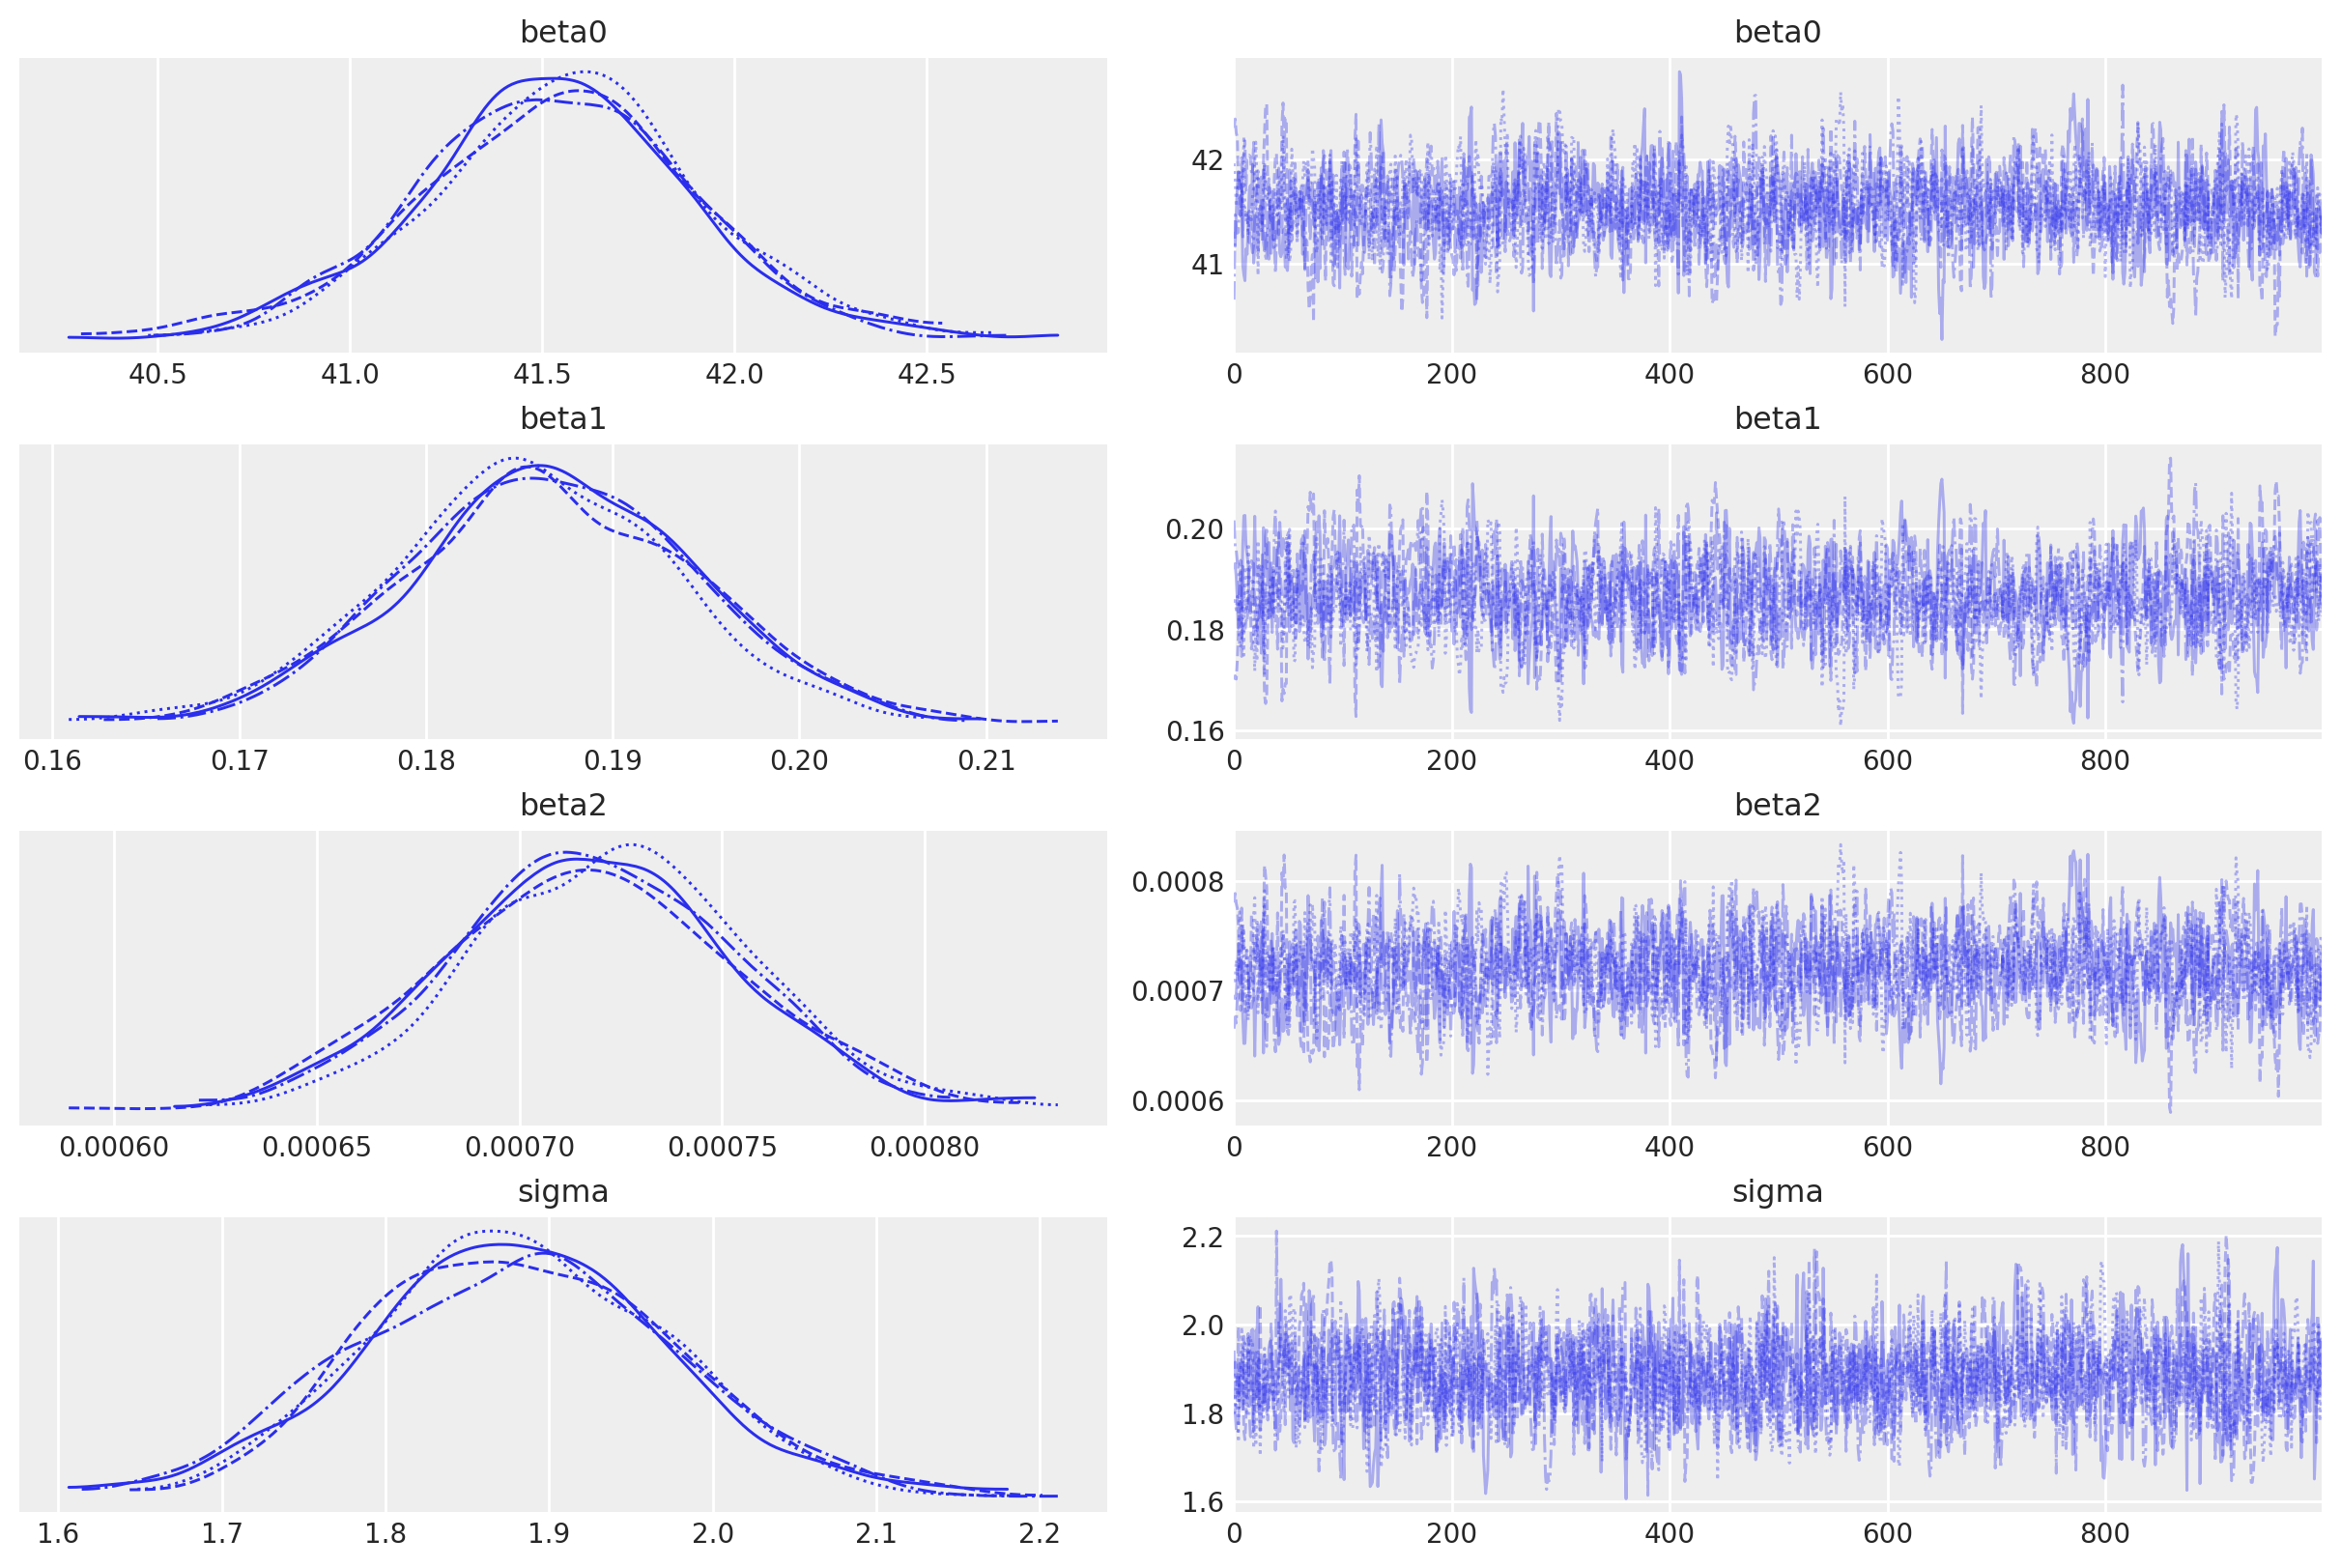

In [ ]:
az.plot_trace(idata, var_names=["~mu"]);

Podemos observar que haciendo 4 trazos diferentes utilizando NUTS (No-U-Turn Sampler), que es una forma de hamiltonian MC; las 4 trazas parecen converger a una distribución similar, del lado derecho vemos como llegan a un estado en el que converge y se queda sampleando la distribución de cada respectivo valor.

#### Verificación Predictiva Posterior

Otro aspecto importante del flujo de trabajo Bayesiano es graficar las predicciones posteriores del modelo, lo que nos permite ver qué tan bien puede el modelo retrodecir los datos ya observados. Es en este punto donde podemos decidir si el modelo es demasiado simple (entonces agregaríamos más complejidad al modelo) o si está bien.


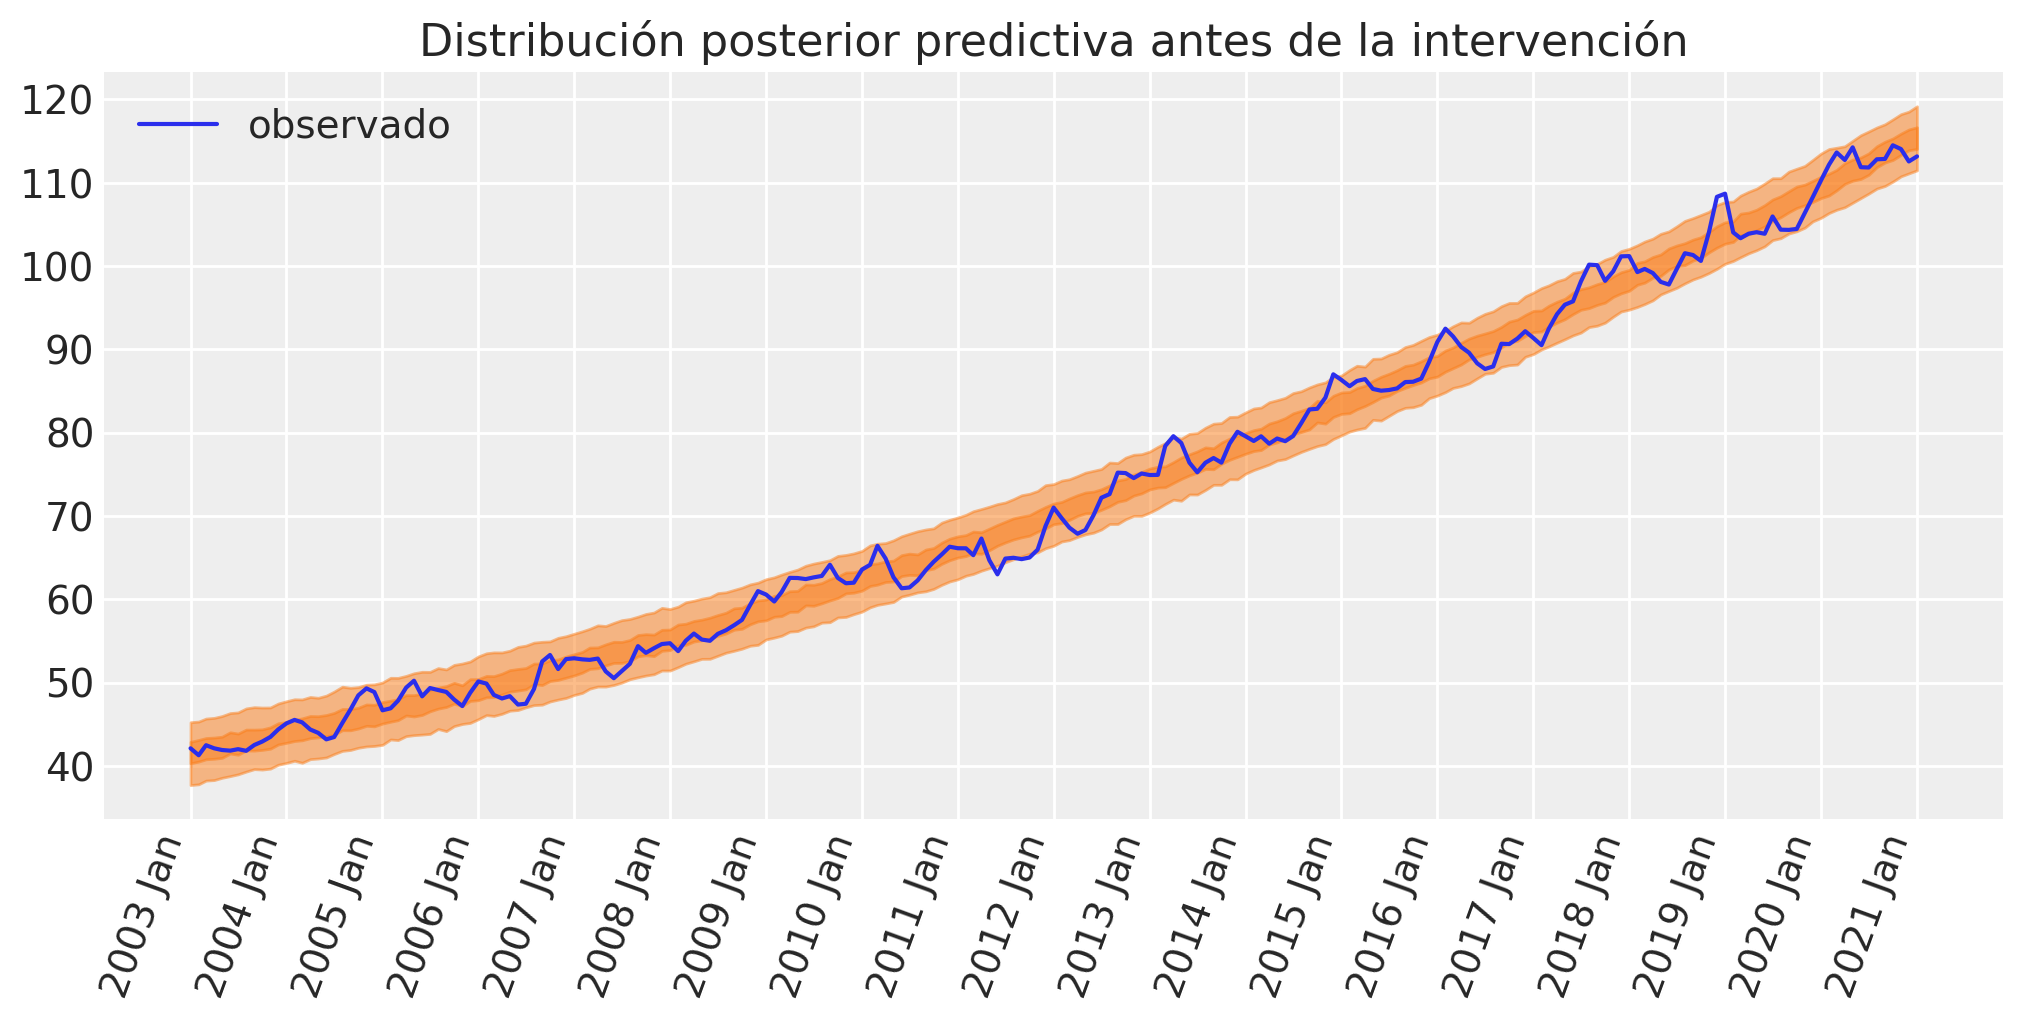

In [ ]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["VALOR"], label="observado")
format_x_axis(ax)
ax.set(title="Distribución posterior predictiva antes de la intervención")
plt.legend();

In [ ]:
y = xr.DataArray(pre["VALOR"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = y - idata.posterior_predictive["obs"]

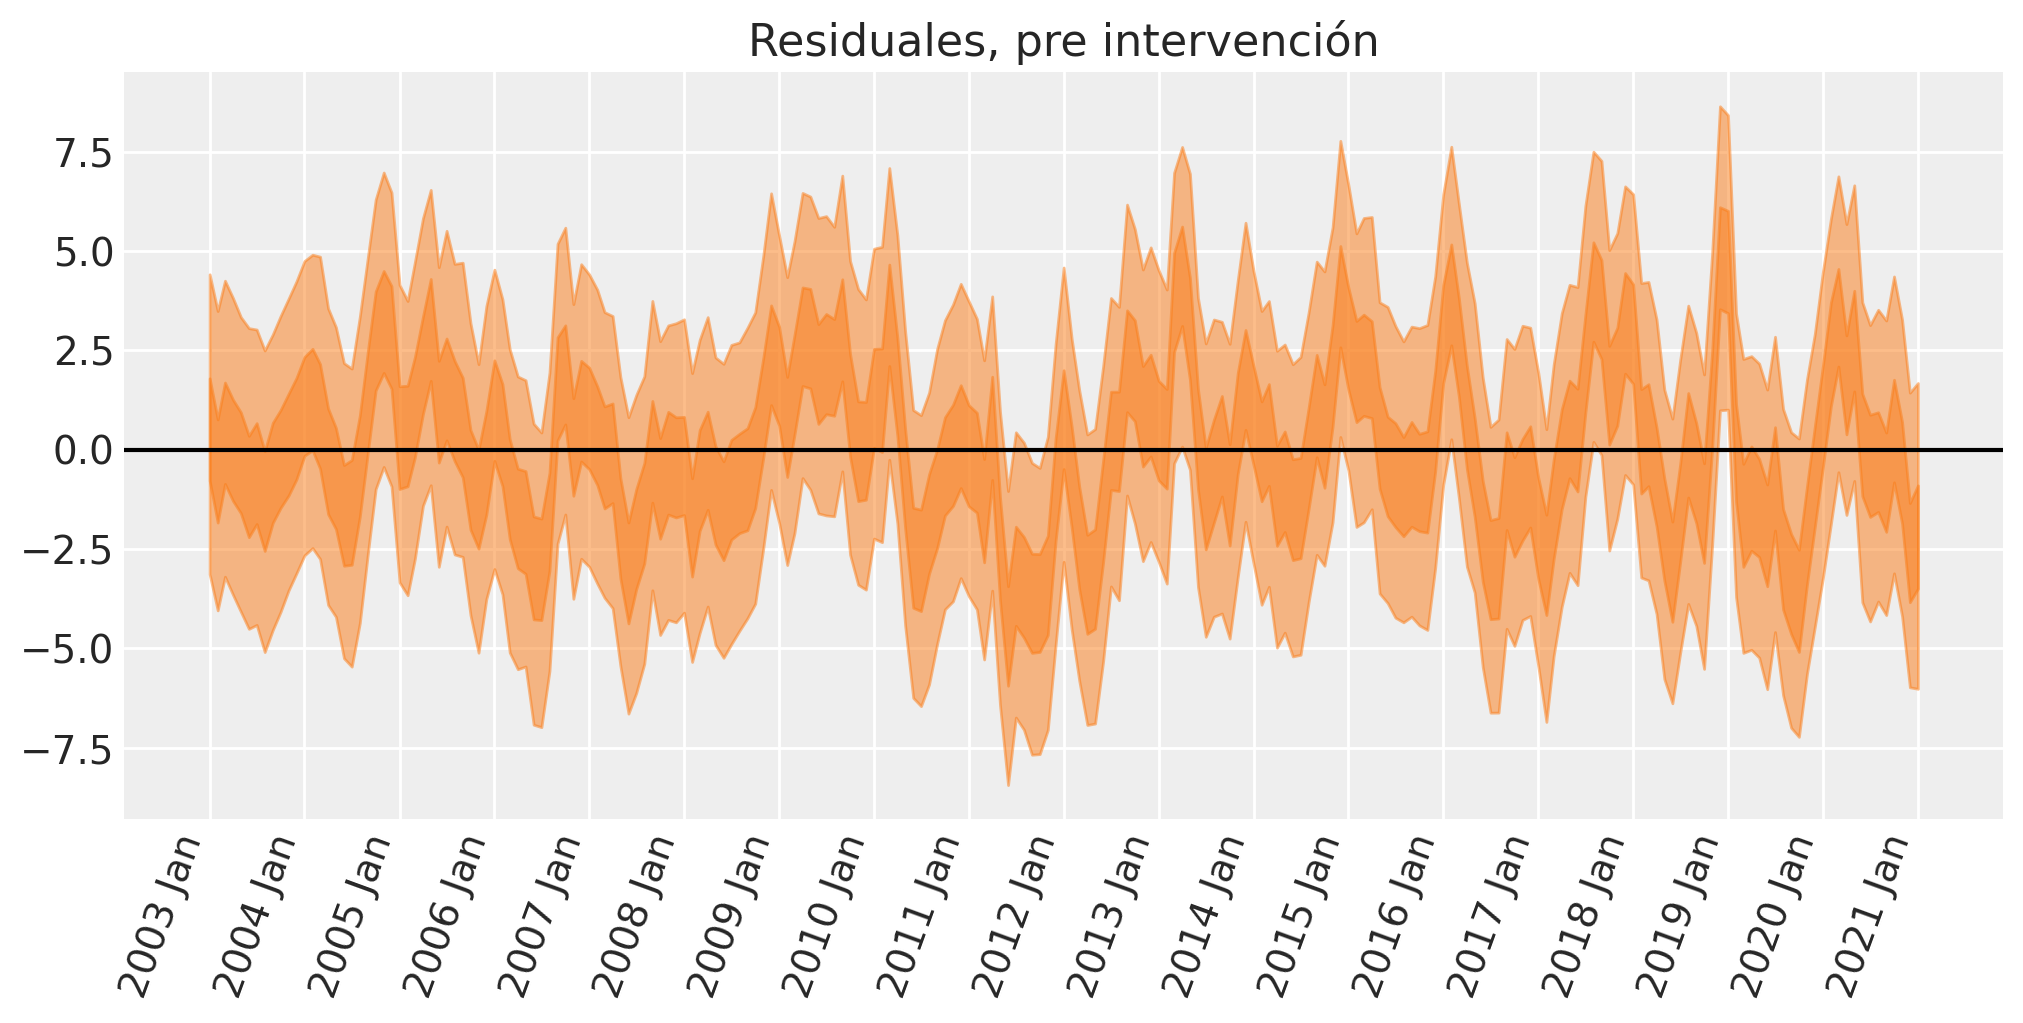

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
# the transpose is to keep arviz happy, ordering the dimensions as (chain, draw, time)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, excess.transpose(..., "obs_id"), hdi_prob=0.95, smooth=False)
format_x_axis(ax)
ax.axhline(y=0, color="k")
ax.set(title="Residuales, pre intervención");

## Inferencia Contrafactual
Ahora utilizaremos nuestro modelo para predecir el resultado observado en el escenario de "¿qué pasaría si?" de no intervención.

Por lo tanto, actualizamos el modelo con los datos de `time` del dataframe `post` intervención y realizamos un muestreo predictivo posterior para predecir las observaciones que observaríamos en este escenario contrafactual. También podríamos llamar a esto 'pronóstico'.


In [ ]:
with model:
    pm.set_data(
        {
            "time": post["time"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=RANDOM_SEED
    )

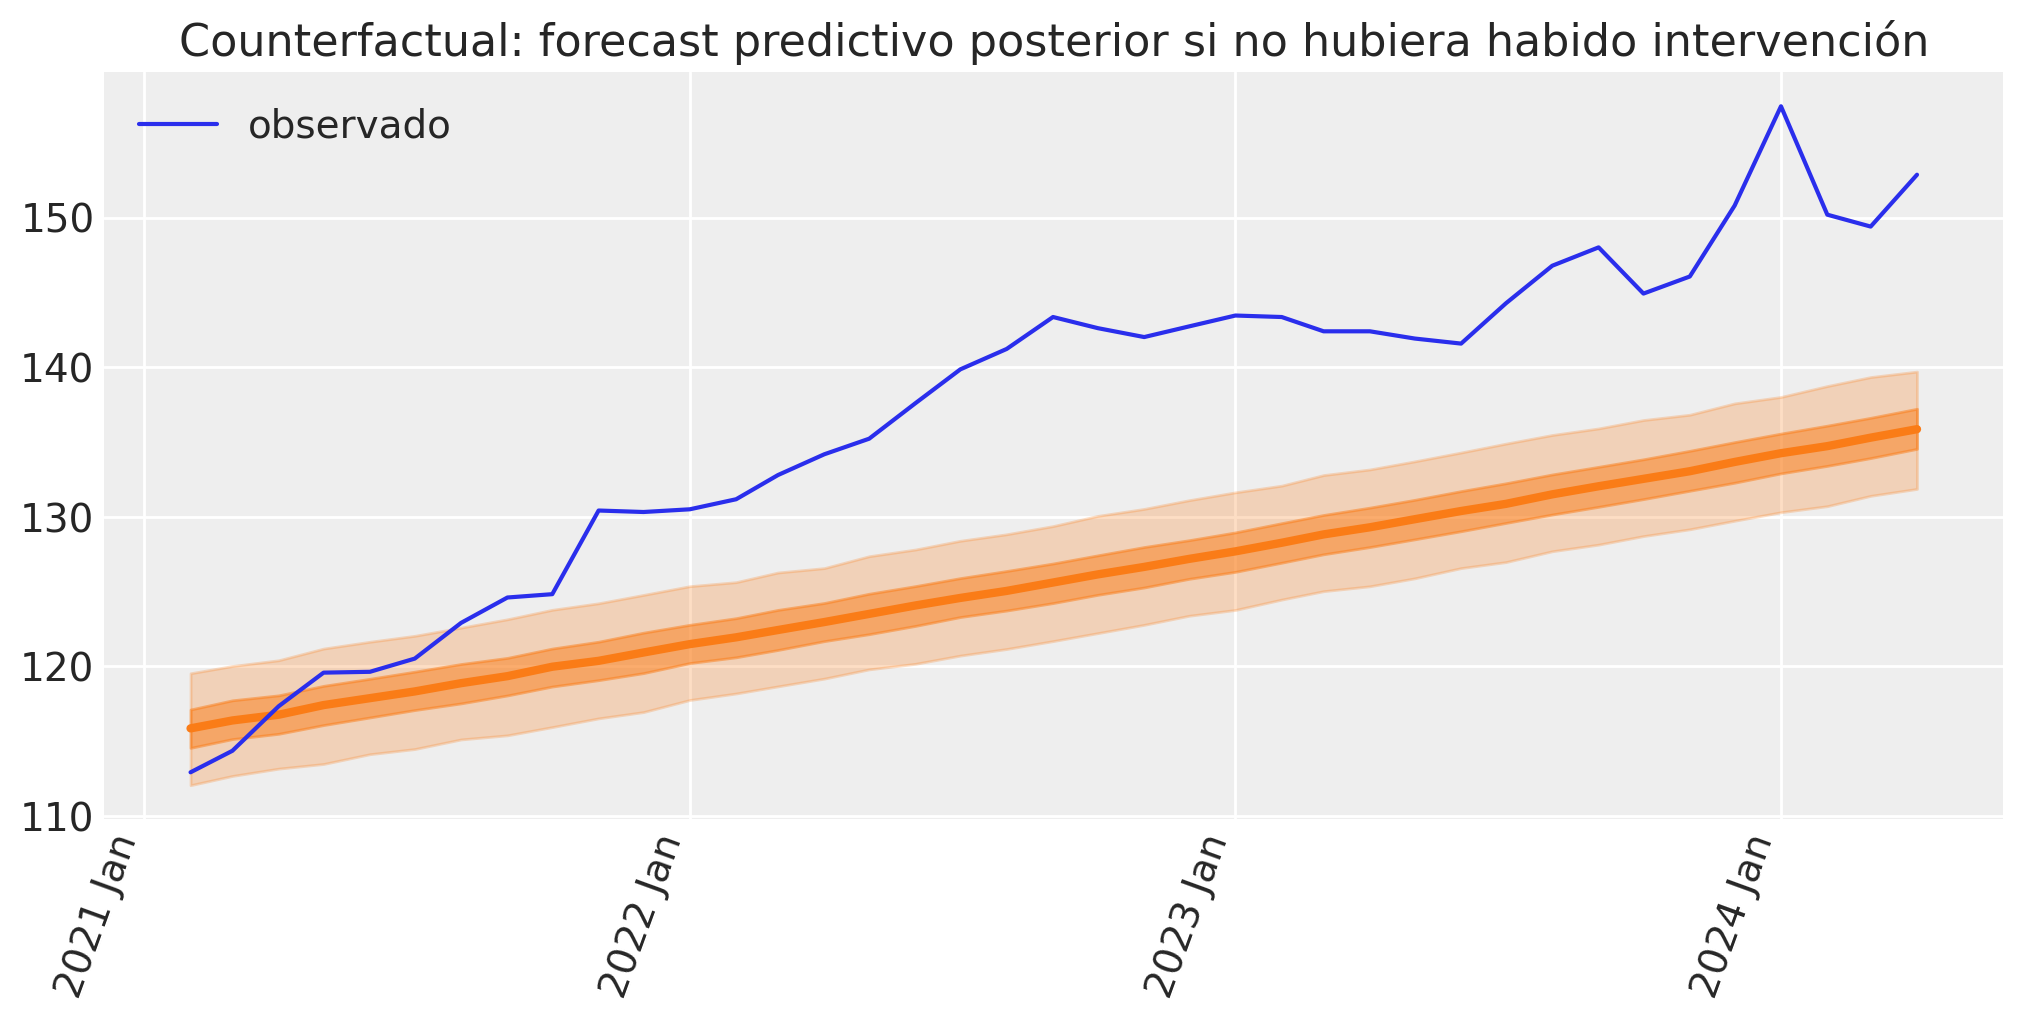

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=False)
ax.plot(post.index, post["VALOR"], label="observado")
ax.set(
    title="Counterfactual: forecast predictivo posterior si no hubiera habido intervención"
)
plt.legend();

Ahora tenemos todo para calcular el impacto causal, esto es simplemente la diferencia entre las predicciones contrafactuales bayesianas y las observaciones

### Impacto Causal desde la intervención

In [ ]:
outcome = xr.DataArray(post["VALOR"].to_numpy(), dims=["obs_id"])

# do the calculation by taking the difference
excess = outcome - counterfactual.posterior_predictive["obs"]

In [ ]:
cumsum = excess.cumsum(dim="obs_id")

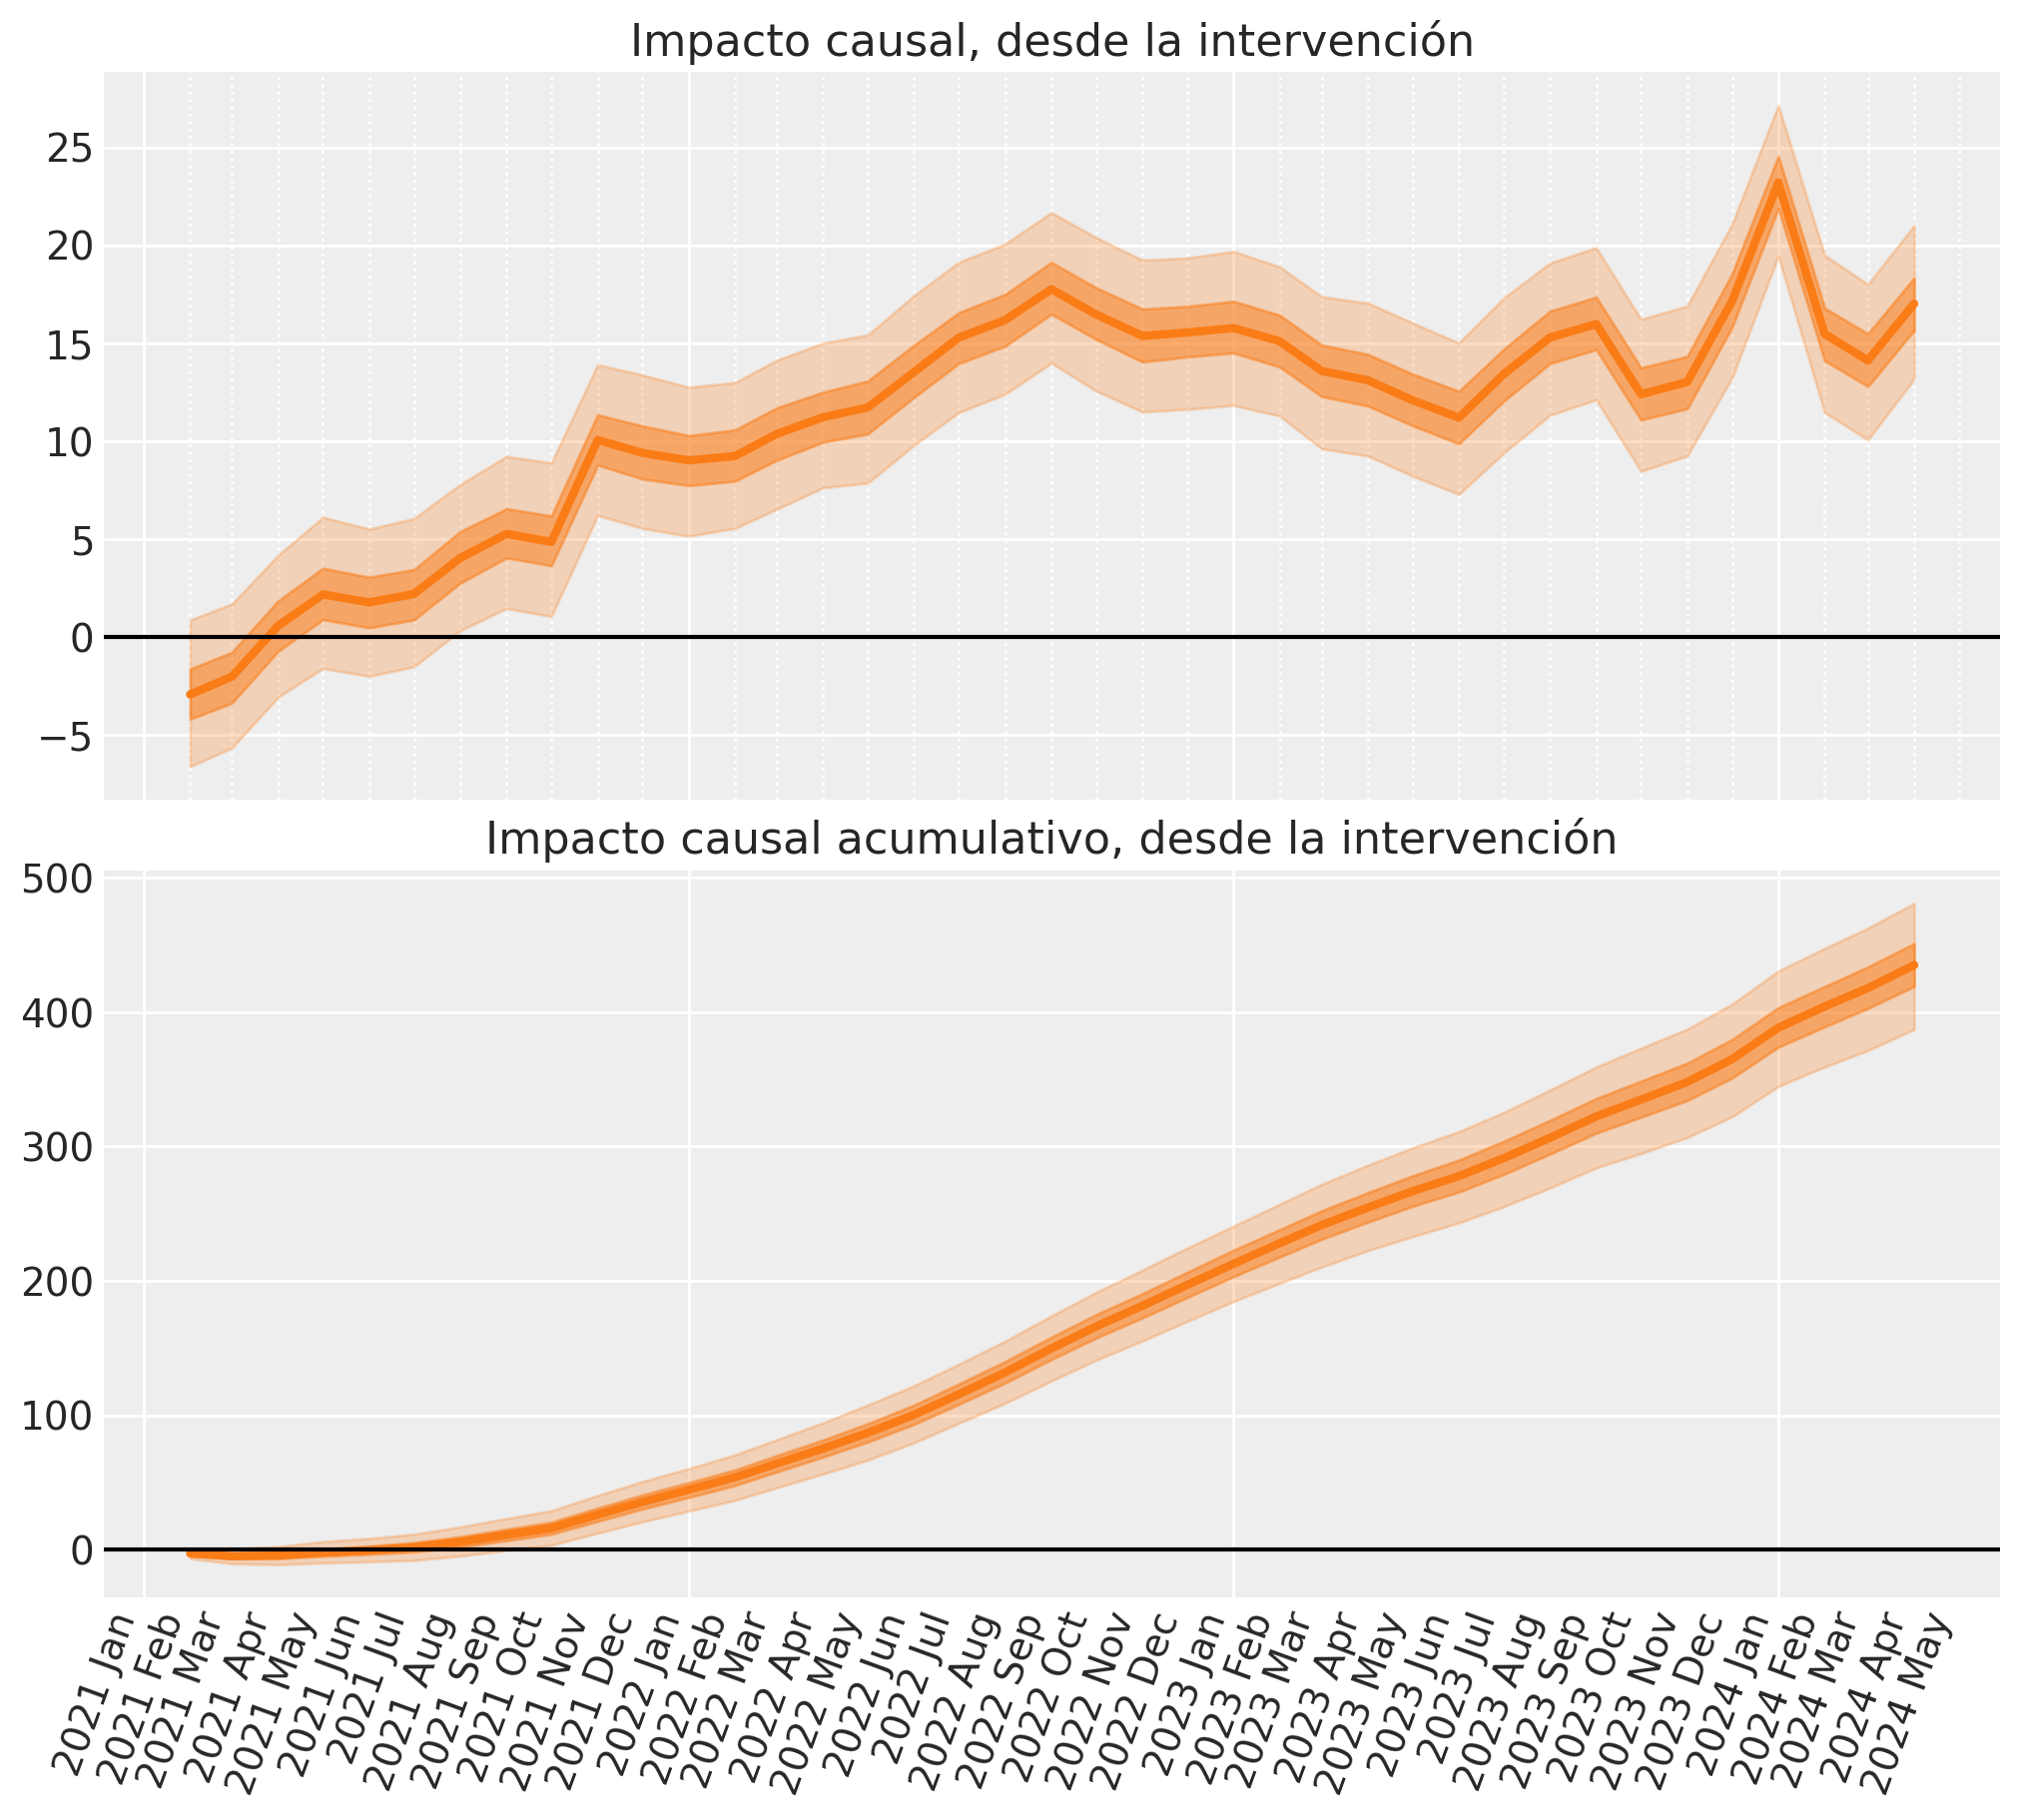

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess.transpose(..., "obs_id"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Impacto causal, desde la intervención")

# Plot the cumulative excess
plot_xY(post.index, cumsum.transpose(..., "obs_id"), ax[1])
format_x_axis(ax[1], minor=False)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Impacto causal acumulativo, desde la intervención");